# Sample Implementation of Decoder from decoder.py
* We flatten an image, train a SegmentNet then use the SegmentNet parameters as input to the decoder and recreate the image

In [1]:
from decoder import Decoder
from segment import Segment

import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timeit
from tqdm import tqdm 


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Get image from MNIST and flatten them

In [17]:
from torchvision import datasets, transforms

flatten_by_row_transform = transforms.Lambda(lambda x: x.flatten())
unflatten_by_row_transform = transforms.Lambda(lambda x: x.view([1,28,28]))
bw_array_transform = transforms.Lambda(lambda x: torch.where(x < x.mean(), 0., 1.))

flatten_by_col_transform = transforms.Lambda(lambda x: x.permute(0,2,1).flatten())
unflatten_by_col_transform = transforms.Lambda(lambda x: x.view([1,28,28]).permute(0,2,1))

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])
])

train_set = datasets.MNIST('data', train=True, download=False, transform=train_transform)
test_set = datasets.MNIST('data', train=False, download=False, transform=test_transform)
print(len(train_set), len(test_set))

60000 10000


In [56]:
# Sample image
test_image, label = train_set[0]
print(test_image.shape, label)

torch.Size([1, 28, 28]) 5


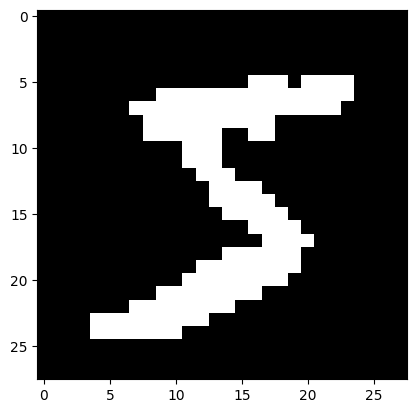

In [135]:
#Convert image to BW ans replace 1st with row position
bw_image = bw_array_transform(test_image)
#yval = torch.arange(bw_image.shape[1]).reshape(1, bw_image.shape[1])
#yval = yval/yval.max()
#xval = torch.arange(bw_image.shape[2]).reshape(bw_image.shape[1],1)
#xval = xval/xval.max()
#bw_image = bw_image*xval
plt.imshow(bw_image.squeeze().numpy(), cmap='gray')
plt.show()

torch.Size([784])
torch.Size([1, 28, 28])


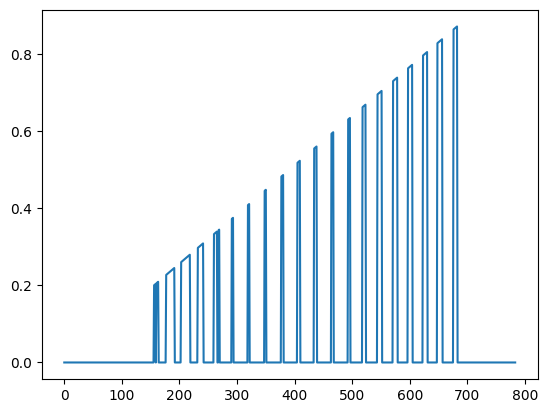

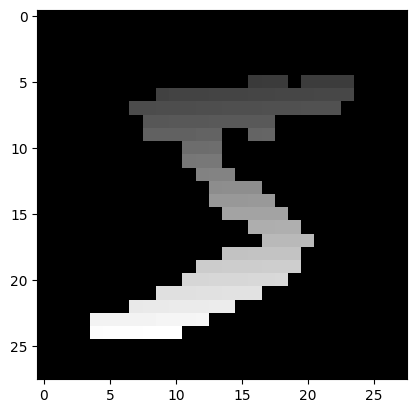

In [137]:
# Test image flatten_by_row_transform
bw_image = bw_array_transform(test_image)

flattened_by_row = flatten_by_row_transform(bw_image)
val = torch.arange(1, flattened_by_row.shape[0]+1.)/flattened_by_row.shape[0] 
flattened_by_row *= val
print(flattened_by_row.shape)
new_img = unflatten_by_row_transform(flattened_by_row)
print(new_img.shape)
torch.equal(new_img, test_image)

plt.plot(np.arange(784), flattened_by_row)
plt.show()
plt.imshow(new_img.squeeze().numpy(), cmap='gray')
plt.show()

torch.Size([784])
torch.Size([1, 28, 28])


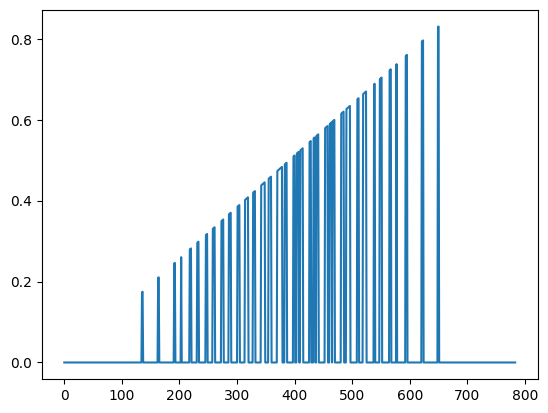

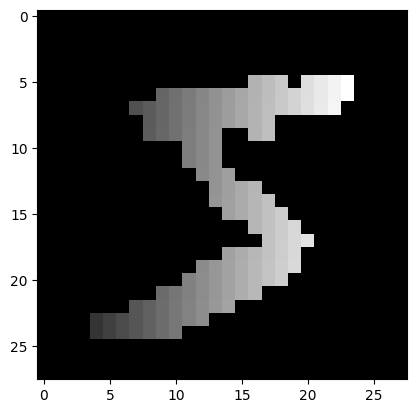

In [138]:
# Test image flatten_by_row_transform
bw_image = bw_array_transform(test_image)

flattened_by_col = flatten_by_col_transform(bw_image)
#val = torch.arange(1, flattened_by_col.shape[0]+1.)/flattened_by_col.shape[0] 
flattened_by_col *= val
print(flattened_by_col.shape)
new_img = unflatten_by_col_transform(flattened_by_col)
print(new_img.shape)
torch.equal(new_img, test_image)

plt.plot(np.arange(784), flattened_by_col)
plt.show()
plt.imshow(new_img.squeeze().numpy(), cmap='gray')
plt.show()

## Create data set

In [165]:
#ytest = torch.stack([flattened_by_row, flattened_by_col], dim=1)
#ytest = flattened_by_row.unsqueeze(-1)
ytest = flattened_by_col.unsqueeze(-1)
print(ytest.shape)
print(ytest.min(), ytest.max())

image_size = ytest.shape[0]
x_in = torch.arange(1, image_size+1)/image_size 
print(x_in.shape)
print(x_in.min(), x_in.max())
x_in = x_in.unsqueeze(-1)
print(x_in.shape)

torch.Size([784, 1])
tensor(0.) tensor(0.8304)
torch.Size([784])
tensor(0.0013) tensor(1.)
torch.Size([784, 1])


In [166]:
ytest.min(), ytest.max(), x_in.min(), x_in.max()

(tensor(0.), tensor(0.8304), tensor(0.0013), tensor(1.))

## Train a Segment model to predict ytest

In [177]:
# Train a model
model = Segment(x_in.shape[1], ytest.shape[1], (28*14)).to(device)
x_in = x_in.to(device)
ytest = ytest.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

#Initialize model parameters - extremely important.
model.custom_init(x_in.min(dim=0).values, x_in.max(dim=0).values)

criterion = nn.MSELoss(reduction='sum')

lr=.00002
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x_in, ytest)
batch_size=32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#Train
num_epochs = 20000
losses = np.array([])
start = timeit.default_timer()
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # Forward pass
        [X, Y] = data
        ypred = model(X)
        # Calculate the loss
        loss = criterion(ypred, Y)
        if math.isnan(loss):
            print("Loss is nan")
            break
        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if math.isnan(loss):
        print("Loss is nan")
        break
    train_loss = train_loss/(batch_idx+1)
    if epoch%(num_epochs/100) == 0:
        stop = timeit.default_timer()
        print(f"Per epoc Training Time: {(stop-start)/epoch:.3f}s")
        losses = np.append(losses, train_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss))

Total parameters: 786
Per epoc Training Time: 0.033s
====> Epoch: 200 Average loss: 1.3942
Per epoc Training Time: 0.039s
====> Epoch: 400 Average loss: 1.2408
Per epoc Training Time: 0.044s
====> Epoch: 600 Average loss: 1.2089
Per epoc Training Time: 0.047s
====> Epoch: 800 Average loss: 1.0903
Per epoc Training Time: 0.048s
====> Epoch: 1000 Average loss: 1.0402
Per epoc Training Time: 0.047s
====> Epoch: 1200 Average loss: 1.0014
Per epoc Training Time: 0.047s
====> Epoch: 1400 Average loss: 0.9559
Per epoc Training Time: 0.047s
====> Epoch: 1600 Average loss: 0.9315
Per epoc Training Time: 0.047s
====> Epoch: 1800 Average loss: 0.8916
Per epoc Training Time: 0.049s
====> Epoch: 2000 Average loss: 0.8671
Per epoc Training Time: 0.049s
====> Epoch: 2200 Average loss: 0.8255
Per epoc Training Time: 0.049s
====> Epoch: 2400 Average loss: 0.7770
Per epoc Training Time: 0.049s
====> Epoch: 2600 Average loss: 0.7357
Per epoc Training Time: 0.051s
====> Epoch: 2800 Average loss: 0.6996
Pe

In [156]:
with torch.no_grad():
    print(model.x.min(), model.x.max(),model.y.min(), model.y.max() )

tensor(-0.0386) tensor(1.2988) tensor(-0.1843) tensor(1.1579)


# Use Decoder to regenerate the image

In [162]:
print(model.x.shape)
segment_x = model.x.reshape(model.x.shape[2], model.x.shape[1])
segment_y = model.y.reshape(model.y.shape[2], model.y.shape[1])
print(segment_x.shape, segment_y.shape)

image_shape = torch.Tensor([ytest.shape[0]])
decoder = Decoder(image_shape)
ydecoded = decoder(segment_x=segment_x, segment_y=segment_y)
ydecoded.shape

torch.Size([1, 393, 2])
torch.Size([2, 393]) torch.Size([2, 393])


torch.Size([2, 784])

## Draw each image

torch.Size([1, 28, 28])


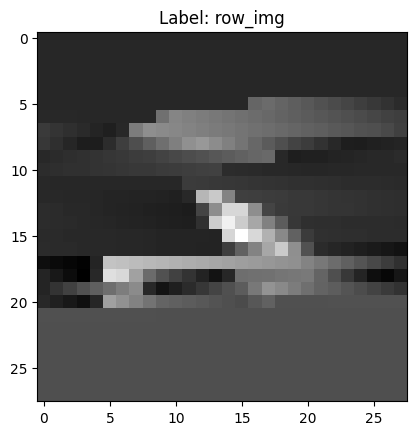

In [163]:
row_img = unflatten_by_row_transform(ydecoded[0])
print(row_img.shape)
plt.imshow(row_img.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Label: row_img")
plt.show()

torch.Size([1, 28, 28])


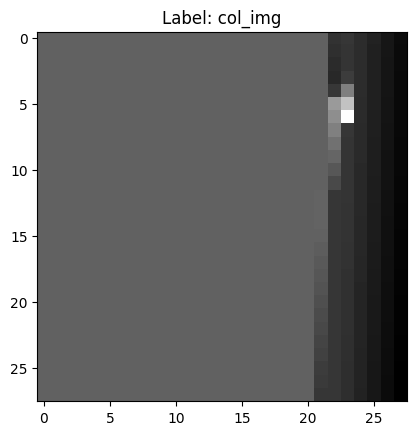

In [164]:
col_img = unflatten_by_col_transform(ydecoded[1])
print(col_img.shape)
plt.imshow(col_img.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Label: col_img")
plt.show()